<center><h1>Han_Brandon_HW7</h1></center>

Name: Brandon Han
<br>
Github Username: hanbrand
<br>
USC ID: 7263220420

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [168]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

### (a) Download the Anuran Calls (MFCCs) Data Set

In [153]:
file_path = "../data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv"
data = pd.read_csv(file_path)

# Load Features and Labels
X_train = data.iloc[:, :20]  # First 20 columns are features
y = data[['Family', 'Genus', 'Species']]  # Target Labels

# Align X_train and y based on their index
X_train, y = X_train.align(y, join='inner', axis=0)

# Split the data into train and test sets (70% train, 30% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.3, random_state=42)

# Align X_train and X_test columns to ensure they match
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# Verify the alignment
print("Aligned X_train shape:", X_train.shape)
print("Aligned X_test shape:", X_test.shape)

# Initialize SMOTE for handling imbalanced data
X_train_balanced, y_train_balanced = None, None

for label in y_train.columns:
    print(f"Processing SMOTE for {label}...")
    y_train_label = y_train[label].values  # Extract current label

    # Check alignment
    if X_train.shape[0] != len(y_train_label):
        print(f"Skipping SMOTE for {label} due to misaligned shapes: X_train ({X_train.shape}), y_train_label ({len(y_train_label)})")
        continue

    # Determine minority class size and initialize SMOTE
    class_counts = pd.Series(y_train_label).value_counts()
    minority_class_count = class_counts.min()
    k_neighbors = max(1, min(2, minority_class_count - 1))  # Ensure k_neighbors >= 1
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)

    try:
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train_label)

        # Combine features and labels for the current label
        if X_train_balanced is None:
            X_train_balanced = X_resampled
            y_train_balanced = pd.DataFrame(y_resampled, columns=[label])
        else:
            # Align feature matrix and label matrix dimensions
            X_train_balanced = np.vstack([X_train_balanced, X_resampled])
            y_resampled_df = pd.DataFrame(y_resampled, columns=[label])
            y_train_balanced = pd.concat([y_train_balanced, y_resampled_df.reset_index(drop=True)], axis=1)

    except ValueError as e:
        print(f"Skipping SMOTE for label '{label}' due to insufficient samples or other errors: {e}")

# Handle the case where no labels were processed
if X_train_balanced is None:
    print("SMOTE could not balance any labels. Check the input dimensions or class distributions.")
    X_train_balanced = np.array([])
    y_train_balanced = pd.DataFrame()

# Final verification
print("Balanced training data shape (features):", None if len(X_train_balanced) == 0 else X_train_balanced.shape)
print("Balanced training data shape (labels):", y_train_balanced.shape)

Aligned X_train shape: (5036, 20)
Aligned X_test shape: (2159, 20)
Processing SMOTE for Family...
Processing SMOTE for Genus...
Processing SMOTE for Species...
Balanced training data shape (features): (59954, 20)
Balanced training data shape (labels): (24470, 3)


### (b) Train a classifier for each label

#### (i) Research

#### (ii) Train a SVM for each of the labels

In [154]:
# Parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Dictionary to store best models and results
best_models = {}
results = {}

# Train an SVM for each label
for label in y_train.columns:
    print(f"Training SVM for {label}...")
    
    # Define the SVM model
    svm = SVC()
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train[label])
    
    # Get the best model and hyperparameters
    best_models[label] = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Test accuracy on X_test
    y_pred = best_models[label].predict(X_test)
    accuracy = accuracy_score(y_test[label], y_pred)
    
    # Store the results
    results[label] = {
        'Best Parameters': best_params,
        'Test Accuracy': accuracy
    }
    
    print(f"Best Parameters for {label}: {best_params}")
    print(f"Test Accuracy for {label}: {accuracy:.4f}")

# Display the results for all labels
print("\nFinal Results:")
for label, result in results.items():
    print(f"{label}:")
    print(f"  Best Parameters: {result['Best Parameters']}")
    print(f"  Test Accuracy: {result['Test Accuracy']:.4f}")

Training SVM for Family...
Best Parameters for Family: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Test Accuracy for Family: 0.9917
Training SVM for Genus...
Best Parameters for Genus: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Test Accuracy for Genus: 0.9889
Training SVM for Species...
Best Parameters for Species: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Test Accuracy for Species: 0.9898

Final Results:
Family:
  Best Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
  Test Accuracy: 0.9917
Genus:
  Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
  Test Accuracy: 0.9889
Species:
  Best Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
  Test Accuracy: 0.9898


#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [155]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Update the parameter grid for better tuning
param_grid_l1 = {
    'C': [0.01, 0.1, 1, 10, 100]
}

# Define the L1-penalized SVM model with a higher max_iter
svm_l1 = LinearSVC(penalty='l1', dual=False, random_state=42, max_iter=100000)

# Perform GridSearchCV
grid_search_l1 = GridSearchCV(svm_l1, param_grid_l1, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_l1.fit(X_train_scaled, y_train[label])

# Get the best model and hyperparameters
best_model_l1 = grid_search_l1.best_estimator_
best_params_l1 = grid_search_l1.best_params_

# Test accuracy on X_test_scaled
y_pred_l1 = best_model_l1.predict(X_test_scaled)
accuracy_l1 = accuracy_score(y_test[label], y_pred_l1)

print(f"Best Parameters for {label}: {best_params_l1}")
print(f"Test Accuracy for {label}: {accuracy_l1:.4f}")

Best Parameters for Species: {'C': 100}
Test Accuracy for Species: 0.9541


#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [156]:
# Initialize variables to store the balanced data
X_train_balanced_smote = None
y_train_balanced_smote = None

# Apply SMOTE for each label
for label in y_train.columns:
    print(f"Applying SMOTE for {label}...")
    
    # Extract the specific target column for the current label
    y_train_label = y_train[label].values  # Convert to 1D array
    
    try:
        # Apply SMOTE for the current label
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train_label)
        
        # Combine resampled features and labels for the current label
        if X_train_balanced_smote is None:
            X_train_balanced_smote = X_resampled
            y_train_balanced_smote = pd.DataFrame(y_resampled, columns=[label])
        else:
            X_train_balanced_smote = np.vstack((X_train_balanced_smote, X_resampled))
            y_resampled_df = pd.DataFrame(y_resampled, columns=[label])
            y_train_balanced_smote = pd.concat([y_train_balanced_smote, y_resampled_df.reset_index(drop=True)], axis=1)
            
    except ValueError as e:
        print(f"Skipping SMOTE for {label} due to insufficient samples or other errors: {e}")

# Final verification of shapes
print("Final balanced training data shape (features):", X_train_balanced_smote.shape)
print("Final balanced training data shape (labels):", y_train_balanced_smote.shape)


Applying SMOTE for Family...
Applying SMOTE for Genus...
Applying SMOTE for Species...
Final balanced training data shape (features): (59954, 20)
Final balanced training data shape (labels): (24470, 3)


In [157]:
# Initialize variables for balanced data
X_train_balanced_smote = None
y_train_balanced_smote = pd.DataFrame(index=X_train.index)  # Initialize DataFrame with correct index

# Apply SMOTE for each label
for label in y_train.columns:
    print(f"Applying SMOTE for {label}...")
    y_train_label = y_train[label].values.flatten()  # Convert to 1D array

    try:
        # Apply SMOTE for the current label
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train_label)

        # Combine resampled data
        if X_train_balanced_smote is None:
            X_train_balanced_smote = X_resampled
            y_train_balanced_smote[label] = y_resampled
        else:
            X_train_balanced_smote = np.vstack((X_train_balanced_smote, X_resampled))
            if label not in y_train_balanced_smote:
                y_train_balanced_smote[label] = pd.Series(dtype='int')  # Initialize column if missing
            y_train_balanced_smote[label] = pd.concat(
                [y_train_balanced_smote[label], pd.Series(y_resampled)], ignore_index=True
            )

    except ValueError as e:
        print(f"Skipping SMOTE for {label} due to insufficient samples or errors: {e}")
        # Ensure the column exists even if SMOTE fails
        if label not in y_train_balanced_smote:
            y_train_balanced_smote[label] = pd.Series(y_train[label].values, index=X_train.index)

# Verify alignment of features and labels after SMOTE
print("Feature matrix shape after SMOTE:", X_train_balanced_smote.shape)
print("Label matrix shape after SMOTE:", y_train_balanced_smote.shape)

# Scale the features
scaler = StandardScaler()
X_train_balanced_smote_scaled = scaler.fit_transform(X_train_balanced_smote)
X_test_scaled = scaler.transform(X_test)

# Train SVM models for each label using SMOTE-balanced dataset
# Apply SMOTE for each label
results_smote = {}
for label in y_train.columns:
    print(f"\nApplying SMOTE for {label}...")
    
    try:
        # Prepare the label-specific data
        y_train_label = y_train[label].values  # Flatten to 1D array if needed
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train_label)
        
        # Reset indices and ensure alignment
        X_resampled = pd.DataFrame(X_resampled).reset_index(drop=True)
        y_resampled = pd.Series(y_resampled).reset_index(drop=True)
        
        print(f"Resampled data shape: X={X_resampled.shape}, y={y_resampled.shape}")
        
        # Scale the data
        scaler = StandardScaler()
        X_resampled_scaled = scaler.fit_transform(X_resampled)
        X_test_scaled = scaler.transform(X_test)
        
        # Train the SVM model
        print(f"Training SVM (RBF kernel) for {label}...")
        svm_rbf = SVC()
        grid_search_rbf = GridSearchCV(
            svm_rbf,
            param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1]},
            cv=10,
            scoring='accuracy',
            n_jobs=-1
        )
        grid_search_rbf.fit(X_resampled_scaled, y_resampled)
        
        # Save the results
        best_model_rbf = grid_search_rbf.best_estimator_
        best_params_rbf = grid_search_rbf.best_params_
        accuracy_rbf = grid_search_rbf.best_score_
        
        results_smote[label] = {
            'Best Parameters (RBF)': best_params_rbf,
            'Test Accuracy (RBF)': accuracy_rbf,
        }
        print(f"Completed training for {label}. Test Accuracy: {accuracy_rbf:.4f}")
    
    except Exception as e:
        print(f"Error processing {label}: {e}")

# Summary table
summary_table = pd.DataFrame(results_smote).T
print("\nSummary of Results:")
print(summary_table)


Applying SMOTE for Family...
Skipping SMOTE for Family due to insufficient samples or errors: Length of values (12292) does not match length of index (5036)
Applying SMOTE for Genus...
Applying SMOTE for Species...
Feature matrix shape after SMOTE: (59954, 20)
Label matrix shape after SMOTE: (5036, 3)

Applying SMOTE for Family...
Resampled data shape: X=(12292, 20), y=(12292,)
Training SVM (RBF kernel) for Family...


C:\Users\Brandon\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Completed training for Family. Test Accuracy: 0.9972

Applying SMOTE for Genus...
Resampled data shape: X=(23192, 20), y=(23192,)
Training SVM (RBF kernel) for Genus...
Completed training for Genus. Test Accuracy: 0.9992

Applying SMOTE for Species...
Resampled data shape: X=(24470, 20), y=(24470,)
Training SVM (RBF kernel) for Species...
Completed training for Species. Test Accuracy: 0.9994

Summary of Results:
             Best Parameters (RBF) Test Accuracy (RBF)
Family     {'C': 10, 'gamma': 0.1}            0.997153
Genus      {'C': 10, 'gamma': 0.1}            0.999181
Species  {'C': 100, 'gamma': 0.01}            0.999387


## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### (a) Use k-means clustering

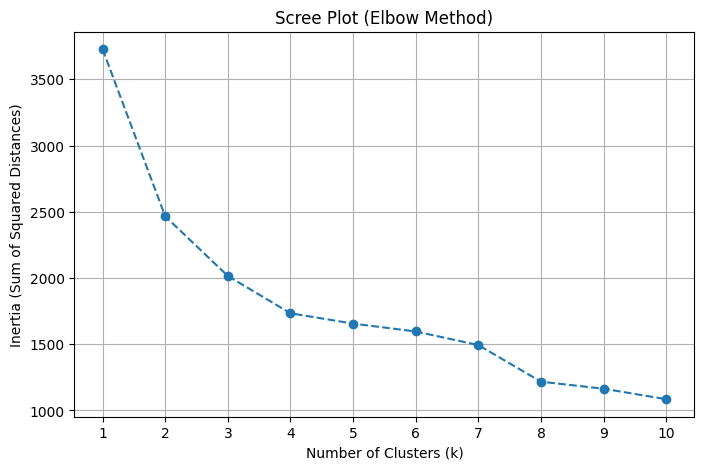

In [158]:
# Define range of cluster numbers
k_values = range(1, 11)  # Test k from 1 to 10
inertias = []  # List to store inertia values

# Compute inertia for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)  # Fit the model on the data
    inertias.append(kmeans.inertia_)

# Plot Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Scree Plot (Elbow Method)')
plt.xticks(k_values)
plt.grid()
plt.show()

### (b) Determine which family is the majority

In [ ]:
# Perform K-Means Clustering with k = 3
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_train)

# Add cluster labels to the true labels for easier grouping
clustered_data = y_train.copy()
clustered_data['Cluster'] = cluster_labels

# Analyze Cluster Composition
for cluster in range(3):  # k=3
    print(f"Cluster {cluster}:")
    cluster_points = clustered_data[clustered_data['Cluster'] == cluster]
    
    # Majority Family
    majority_family = cluster_points['Family'].value_counts().idxmax()
    family_count = cluster_points['Family'].value_counts().max()
    print(f"  Majority Family: {majority_family} (Count: {family_count})")
    
    # Majority Genus
    majority_genus = cluster_points['Genus'].value_counts().idxmax()
    genus_count = cluster_points['Genus'].value_counts().max()
    print(f"  Majority Genus: {majority_genus} (Count: {genus_count})")
    
    # Majority Species
    majority_species = cluster_points['Species'].value_counts().idxmax()
    species_count = cluster_points['Species'].value_counts().max()
    print(f"  Majority Species: {majority_species} (Count: {species_count})")
    print()

### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

In [160]:
# Reassign majority labels to each cluster
hamming_results = {}
for level in ['Family', 'Genus', 'Species']:
    hamming_distance = 0
    
    for cluster in range(3):  # Iterate over clusters
        cluster_points = clustered_data[clustered_data['Cluster'] == cluster]
        
        # Majority label for the current cluster
        majority_label = cluster_points[level].value_counts().idxmax()
        
        # Assign majority label to all points in the cluster
        clustered_data.loc[clustered_data['Cluster'] == cluster, f"Assigned_{level}"] = majority_label
        
        # Calculate mismatches (Hamming distance)
        mismatches = (cluster_points[level] != majority_label).sum()
        hamming_distance += mismatches
    
    # Normalize Hamming distance by total points
    hamming_results[level] = hamming_distance / len(clustered_data)

# Print the results
print("Hamming Distances:")
for level, hamming in hamming_results.items():
    print(f"  {level}: {hamming:.4f}")


Hamming Distances:
  Family: 0.2254
  Genus: 0.2941
  Species: 0.3165


## 3. ISLR 12.6.2

### (a) On the basis of this dissimilarity matrix, sketch the dendrogram that results from hierarchically clustering these four observtions using complete linkage. Be sure to indicate on the plot the height at which each fusion occurs, as well as the observations corresponding to each leaf in the dendrogram.

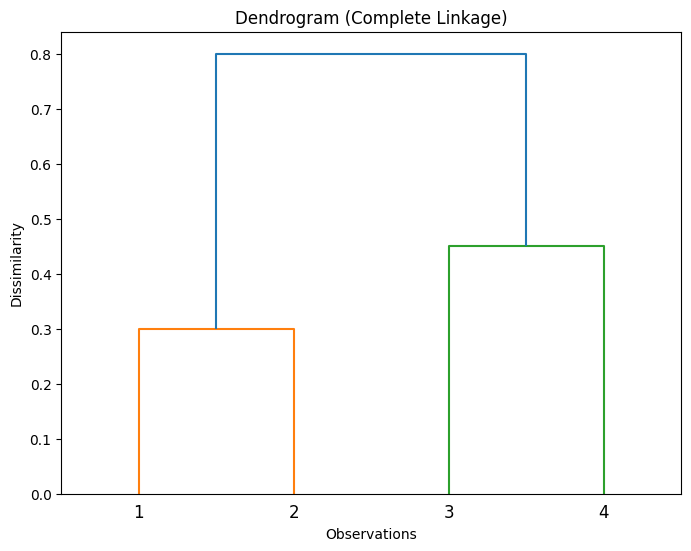

In [165]:
# Dissimilarity matrix (convert to condensed form for linkage)
dissimilarity_matrix = np.array([
    [0, 0.3, 0.4, 0.7],
    [0.3, 0, 0.5, 0.8],
    [0.4, 0.5, 0, 0.45],
    [0.7, 0.8, 0.45, 0]
])
condensed_matrix = dissimilarity_matrix[np.triu_indices(4, k=1)]

# Perform hierarchical clustering using Complete Linkage
complete_linkage = linkage(condensed_matrix, method='complete')

# Plot the dendrogram
plt.figure(figsize=(8, 6))
dendrogram(complete_linkage, labels=['1', '2', '3', '4'], color_threshold=0.5)
plt.title("Dendrogram (Complete Linkage)")
plt.xlabel("Observations")
plt.ylabel("Dissimilarity")
plt.show()

### (b) Repeat (a), this time using single linkage clustering.

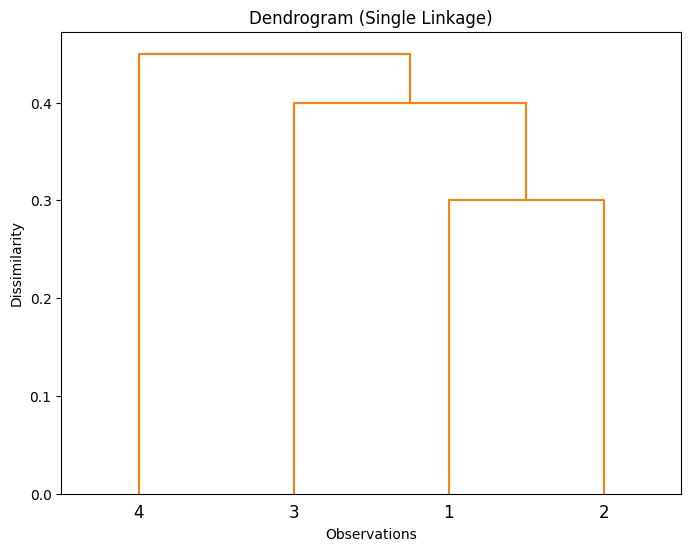

In [166]:
# Perform hierarchical clustering using Single Linkage
single_linkage = linkage(condensed_matrix, method='single')

# Plot the dendrogram
plt.figure(figsize=(8, 6))
dendrogram(single_linkage, labels=['1', '2', '3', '4'], color_threshold=0.5)
plt.title("Dendrogram (Single Linkage)")
plt.xlabel("Observations")
plt.ylabel("Dissimilarity")
plt.show()


### (c) Suppose that we cut the dendrogram obtained in (a) such that two clusters result. Which observations are in each cluster?

In [169]:
# Cut the dendrogram at the height that results in 2 clusters
complete_clusters = fcluster(complete_linkage, t=2, criterion='maxclust')
print("Complete Linkage Clusters (k=2):", complete_clusters)

Complete Linkage Clusters (k=2): [1 1 2 2]


### (d) Suppose that we cut the dendrogram obtained in (b) such that two clusters result. Which observations are in each cluster?

In [170]:
# Cut the dendrogram at the height that results in 2 clusters
single_clusters = fcluster(single_linkage, t=2, criterion='maxclust')
print("Single Linkage Clusters (k=2):", single_clusters)


Single Linkage Clusters (k=2): [1 1 1 2]


### (e) It is mentioned in the chapter that at each fusion in the dendrogram, the position of the two clusters being fused can be swapped without changing the meaning of the dendrogram. Draw a dendrogram that is equivalent to the dendrogram in (a), for which two or more of the leaves are repositioned, but for which the meaning of the dendrogram is the same.

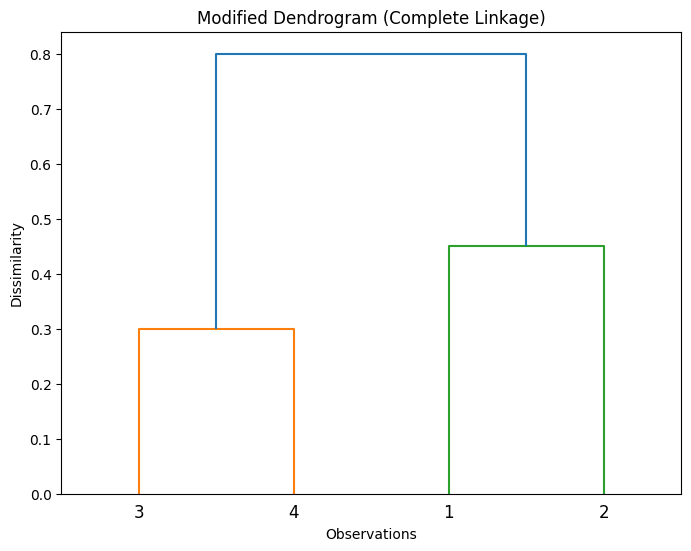

In [171]:
# Reorder leaves manually (swap leaves or nodes) to produce equivalent dendrogram
plt.figure(figsize=(8, 6))
dendrogram(
    complete_linkage,
    labels=['3', '4', '1', '2'],  # Example of swapped labels
    color_threshold=0.5
)
plt.title("Modified Dendrogram (Complete Linkage)")
plt.xlabel("Observations")
plt.ylabel("Dissimilarity")
plt.show()
